<a href="https://colab.research.google.com/github/lzyxts/DQN/blob/main/2_Portfolio_Rebalancing_with_Deep_Q_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#### **Author:** Ivy Ling
#### **Date:** Jun 30, 2024

# Abstract

Portfolio rebalancing is essential for individual investors to maintain target exposure to desired asset classes and achieve strong risk-adjusted returns over time. Traditionally, this process has required human intervention to make timely adjustments. This project aims to explore the potential of deep reinforcement learning in portfolio rebalancing. By training an agent to make intelligent, independent decisions based on current market conditions, the goal is to reduce operational effort and uncover valuable insights that human investors could learn from the trained agent.

In [5]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [6]:
import numpy as np
import pandas as pd
import yfinance as yf
import datetime

import torch
import torch.nn as nn
import torch.nn.functional as F

from datetime import datetime
import itertools
import re
import os
import pickle

import matplotlib.pyplot as plt
import seaborn as sns

np.set_printoptions(precision=2,suppress=True)

In [7]:
# Create a folder to save relevant output files
folder = '/content/drive/MyDrive/DQN/'
if not os.path.exists(folder):
  os.makedirs(folder)

# Deep Q-Learning Set Up

Q-learning is a reinforcement learning algorithm where an agent learns to make decisions by performing actions in an environment to maximize cumulative rewards. However, traditional Q-learning struggles with large and potentially infinite state spaces, common in complex environments like financial markets. To address this, neural networks are used. Deep Q-learning (DQN) employs neural networks to approximate the optimal Q-function, taking a state from high-dimensional state spaces as input.

In this project, the Q-learning context is set as follows:

* **State:** The holding positions and current market condition, comprising two parts: trading information on selected assets (e.g., closing prices) and economic indicators. Economic indicators are believed to influence the behavior of trading assets.

* **Action:** The target allocation for the next day. While there are theoretically infinite target allocations, we make the action space finite. If there are `n` available trading assets, the agent can choose to invest or not invest (`0 or 1`) in each asset, with cash considered another trading asset. The final allocation is pro-rated to each class based on the portfolio value at the end of each trading day. This results in `2^(n+1)-1` possible actions/target allocations. Note that the action space grows exponentially as the number of trading assets increases.

* **Reward:** The absolute daily dollar return on the portfolio holdings.

## Market Data

The market data comprises two parts:

1.   **Trading Information**

Four ETFs are selected for this project to represent different asset classes available to individual investors, covering the period from `2015-01-30` to `2024-05-02`.

*   QQQ - Equities
*   TLT - Bonds
*   GLD - Gold
*   VIXM - Volatility

After downloading the closing prices and volumes from Yahoo Finance, we compute the daily returns, short-term moving averages, and long-term moving averages. Any NAs are removed from the dataset.

2.   **Economic Indicators**

Sourced from Trading Economics, this data includes both actual and consensus figures, with the difference calculated as the surprise term, signaling the agent to act based on the unexpected results. Key indicators include the target interest rate, MoM CPI, QoQ GDP, YoY inflation, and monthly payroll data. Monthly data is extended to daily trading data by filling in with the latest available figures.

The final dataset is of shape 2268 * 30. Pre-processing code and further data analysis are provided in the Appendix.

In [8]:
data_file = 'data.csv'
df = pd.read_csv(data_file)

tickers = ['QQQ', 'TLT', 'GLD', 'VIXM']

In [9]:
print(df.shape)
df.head()

(2268, 30)


,QQQ Close,TLT Close,GLD Close,VIXM Close,QQQ daily_ret,TLT daily_ret,GLD daily_ret,VIXM daily_ret,QQQ Vol,TLT Vol,...,Day_in_month,Target Rate,Core Inflation Rate MoM_Actual,Core Inflation Rate MoM_Surprise,GDP Growth Rate QoQ_Actual,GDP Growth Rate QoQ_Surprise,Inflation Rate YoY_Actual,Inflation Rate YoY_Surprise,Non Farm Payrolls_Actual,Non Farm Payrolls_Surprise
0,102.582932,103.368324,115.330002,57.959999,-0.002533,0.000000,0.020168,0.009756,31121300,4334900,...,27,0.25,0.017,0.001,0.022,0.000,0.000,0.001,295000.0,11000.0
1,102.378242,101.942741,116.330002,56.980000,-0.001995,-0.013791,0.008671,-0.016908,36849200,7464300,...,28,0.25,0.017,0.001,0.022,0.000,0.000,0.001,295000.0,11000.0
2,101.736290,100.693428,115.510002,57.669998,-0.006270,-0.012255,-0.007049,0.012109,34043900,11554800,...,29,0.25,0.017,0.001,0.022,0.000,0.000,0.001,295000.0,11000.0
3,100.136047,100.869598,113.470001,58.130001,-0.015729,0.001750,-0.017661,0.007976,44080500,12876000,...,30,0.25,0.018,0.001,0.002,-0.008,-0.001,-0.001,126000.0,-99000.0
4,101.457191,99.511749,113.080002,57.009998,0.013193,-0.013461,-0.003437,-0.019267,32874300,12378500,...,1,0.25,0.018,0.001,0.002,-0.008,-0.001,-0.001,126000.0,-99000.0


Then we take dividends and coupon into consideration since they are not captured by the closing price, but is the real return that an investor receive at each month by convention. We take the current yield of 4% and converted into daily return.

In [10]:
# take dividends and coupon into consideration
bond_annual_yield = 0.04
daily_yield = (1 + bond_annual_yield) ** (1 / 360) - 1
df['TLT daily_ret'] = df['TLT daily_ret'] + daily_yield
df.head()

,QQQ Close,TLT Close,GLD Close,VIXM Close,QQQ daily_ret,TLT daily_ret,GLD daily_ret,VIXM daily_ret,QQQ Vol,TLT Vol,...,Day_in_month,Target Rate,Core Inflation Rate MoM_Actual,Core Inflation Rate MoM_Surprise,GDP Growth Rate QoQ_Actual,GDP Growth Rate QoQ_Surprise,Inflation Rate YoY_Actual,Inflation Rate YoY_Surprise,Non Farm Payrolls_Actual,Non Farm Payrolls_Surprise
0,102.582932,103.368324,115.330002,57.959999,-0.002533,0.000109,0.020168,0.009756,31121300,4334900,...,27,0.25,0.017,0.001,0.022,0.000,0.000,0.001,295000.0,11000.0
1,102.378242,101.942741,116.330002,56.980000,-0.001995,-0.013682,0.008671,-0.016908,36849200,7464300,...,28,0.25,0.017,0.001,0.022,0.000,0.000,0.001,295000.0,11000.0
2,101.736290,100.693428,115.510002,57.669998,-0.006270,-0.012146,-0.007049,0.012109,34043900,11554800,...,29,0.25,0.017,0.001,0.022,0.000,0.000,0.001,295000.0,11000.0
3,100.136047,100.869598,113.470001,58.130001,-0.015729,0.001859,-0.017661,0.007976,44080500,12876000,...,30,0.25,0.018,0.001,0.002,-0.008,-0.001,-0.001,126000.0,-99000.0
4,101.457191,99.511749,113.080002,57.009998,0.013193,-0.013352,-0.003437,-0.019267,32874300,12378500,...,1,0.25,0.018,0.001,0.002,-0.008,-0.001,-0.001,126000.0,-99000.0


We further declare some variables and do train-test split

In [11]:
# Convert into a numpy array
data = df.values

# Number of stocks
n_stocks = len(tickers)
N, df_dim = data.shape

# Train-test split
n_train = int(N * 0.75)

train_data = data[:n_train]
test_data = data[n_train:]

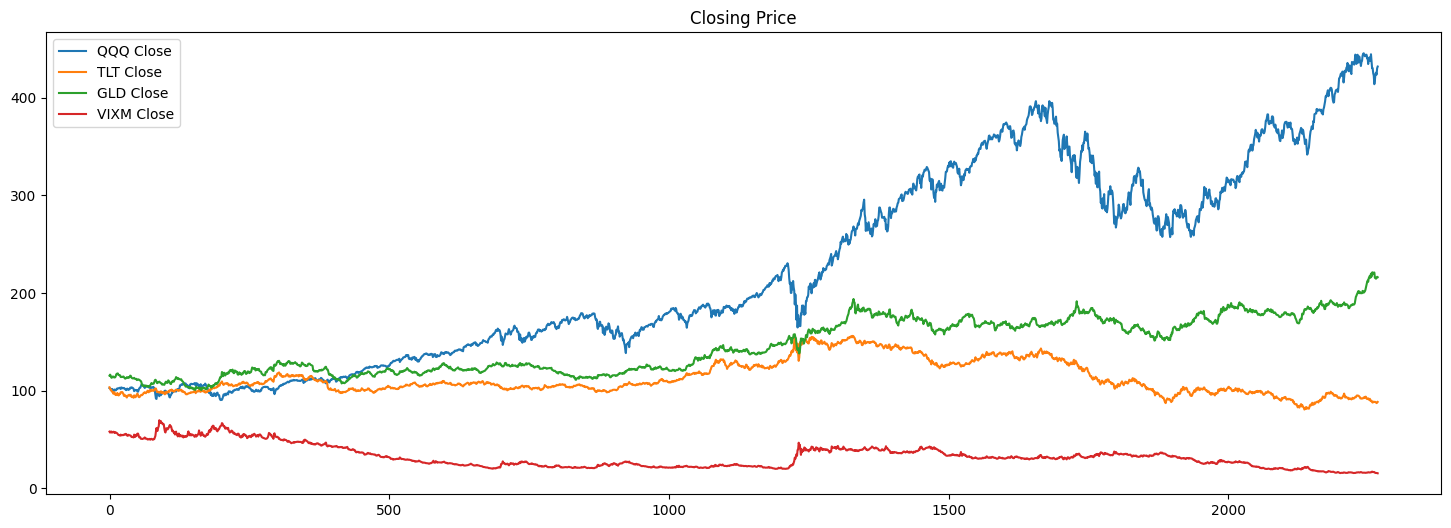

In [12]:
# Plotting a Price chart
close = df.iloc[:, :n_stocks]
dai_ret = df.iloc[:, n_stocks:2*n_stocks]

plt.figure(figsize=(18, 6))
for column in close.columns:
    plt.plot(close[column], label=column)

plt.title('Closing Price')
plt.legend()

# Environment

In the implementation of MarketEnv class, several characteristics of modern brokerage accounts are incorporated. These include the ability to trade fractional shares, with low trading costs applied only upon selling assets, and a zero-commission fee structure.

Agents start their holdings with certain amount of initial cash. They interact with the environment by taking actions(i.e. placing trades), after which the environment returns the rewards and the next state.


In [13]:
import sys
sys.path.append('/content/drive/MyDrive/DQN')
import env

# With the initial investment of $50k, the transaction cost is minimal thus set to 0.
# We keep this assumption throughout the project.
# the tran_cost is expressed by the basis term, a 2 basis point transaction cost would be set to 0.0002 as input.
market = env.MarketEnv(train_data, n_stocks, initial_investment=50000, tran_cost=0.0)

# Get the state and action size for the agent
state_size = market.state_dim
action_size = market.action_space_dim

Run a sample episode to get a normalized scaler for further use.

In [14]:
from sklearn.preprocessing import StandardScaler

def get_scaler(env):
    # Initialize an empty list to store states
    states = []

    # Reset the environment to its initial state
    env.reset()

    for _ in range(env.n_step):
        # Run a sample episode to get a set of simulated states
        action = np.random.choice(env.action_space_dim)
        state, reward, done, info = env.step(action)
        states.append(state)

        if done:
            break

    scaler = StandardScaler()
    # Fit the scaler to the collected states
    scaler.fit(states)

    return scaler

In [15]:
timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')

scaler = get_scaler(market)

# Save the scaler object
with open(f'{folder}/scaler_{timestamp}.pkl', 'wb') as f:
    pickle.dump(scaler, f)

## Model

The neural network model is fairly straightforward. It is default to 2 hidden layers, each followed by a ReLU activation function, and each layer has a hidden dimension of 32 units. The model uses MSE as the loss function and Adam optimizer. The learning rate of the optimizer is set to 0.01.

In [16]:
import agent

# Initialize an NN model
model = agent.MLP(state_size, action_size)

## Agent

The agent's primary function is to decide which action to take based on the current state. The simplest approach is for the agent to select a random action from the action space. Conversely, a highly trained agent will choose the action that maximizes the Q-value, as predicted by the model.

There are several key features within the agent class:

**Replay Buffer**: The agent uses a replay buffer to randomly sample a batch of previously experienced states for training the model. This approach helps to reduce the correlation between consecutive steps, thereby improving the learning process.

**Epsilon-Greedy** Strategy: During training, the agent determines its actions using an epsilon-greedy strategy, which balances exploration and exploitation of the current state. This strategy allows the agent to explore new actions while still taking advantage of the learned model.

**Dual Neural Networks**: The agent employs two neural networks, known as the online model and the target model, to enhance training stability. The online model is trained to predict the Q-values, while the target model, a copy of the online model, is used to predict the target Q-values. The parameters of the target model are updated less frequently than those of the online model. These networks work together to provide more reliable and consistent results.

In [17]:
# Initialize an agent object
agent1 = agent.DQNAgent(state_size, action_size, model)

# Training


In [18]:
def play_one_episode(agent, env, scaler, is_train):
    """
    Play one episode in the environment using the provided agent.
    """
    state = env.reset()  # Reset the MarketEnv to start fresh
    state = scaler.transform([state])  # Normalize the state
    done = False

    # Initialize lists to store actions and portfolio values
    actions = []
    port_val = []

    while not done:
        action = agent.act(state)  # choose an action based on the current state
        actions.append(action)

        # Take the action in the environment and observe the next state, reward, and done flag
        next_state, reward, done, info = env.step(action, verbose=False)
        next_state = scaler.transform([next_state])  # Normalize the next state using the scaler
        port_val.append(info['cur_val'])

        if is_train:
            # Update the agent's replay memory
            agent.update_replay_memory(state, action, reward, next_state, done)
            # Train the model using a sample batch from the replay memory
            agent.replay(batch_size)

        state = next_state  # Update the current state to the next state

    return port_val, actions

The hyperparameters were lightly tuned by running a smaller number of episodes and selecting the configuration that resulted in the highest average portfolio return on the training dataset.

In [15]:
num_train_episodes = 200   # Total number of episodes to train
batch_size = 32            # Batch size for the replay buffer
update_target_every = 20   # Number of episodes after which to update the target model
portfolio_values = []      # Initialize a list to store the training process

# Initialize the training market environment
market = env.MarketEnv(train_data, n_stocks, initial_investment=50000, tran_cost=0.0)
# Initialize the model and agent
model = agent.MLP(state_size, action_size, n_hidden_layers=2, hidden_dim=32)
agent1 = agent.DQNAgent(state_size, action_size, model)
agent1.epsilon_min = 0.2

for i in range(num_train_episodes):
    t0 = datetime.now()  # Get the time it costs for one episode
    # Play one episode in the environment
    port_val, actions = play_one_episode(agent1, market, scaler, is_train=1)
    dt = datetime.now() - t0

    if i % update_target_every == 0:
        # Update the target model periodically to improve training performance
        agent1.update_target_model()

    # For informational purposes
    if i % 100 == 0:
        print(f"episode: {i + 1}/{num_train_episodes}, ending port val: {port_val[-1]:.2f}, duration: {dt}")

    # Append the ending portfolio value to the list
    portfolio_values.append(port_val[-1])

episode: 1/200, ending port val: 65931.02, duration: 0:00:03.964474
episode: 101/200, ending port val: 99639.26, duration: 0:00:03.962933


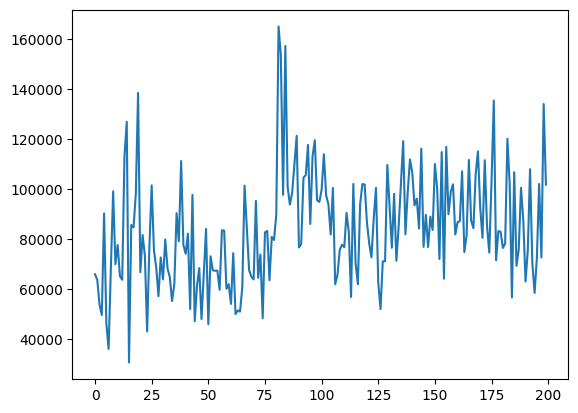

In [16]:
# save trained model for future use
agent1.save(f'{folder}/agent1_{timestamp}.ckpt')

plt.plot(portfolio_values)

# Testing Result

In [19]:
timestamp = '20240629_035403'

In [20]:
# Initialize the testing market environment
testenv = env.MarketEnv(test_data, n_stocks, initial_investment=50000, tran_cost=0.0)

# Load scaler for testing data normalization
import pickle
with open(f'scaler_{timestamp}.pkl', 'rb') as f:
    scaler = pickle.load(f)

To evaluate the performance of our deep Q-learning agent, we compare it against two benchmark agents. The first benchmark is a naive agent that takes random actions throughout the entire period. The second benchmark is a traditional agent that starts with an allocation of 60% in stocks and 40% in bonds. It's important to note that this specific allocation is not directly available for our agent to select; the closest allocation our agent can achieve is 50% in each asset. We simulate the performance of these benchmark agents using the testing data.

Benchmark 1 port ending val mean: 43941.08, risk of the last episode: 3484.51


Text(0.5, 1.0, 'Benchmark 1 Performance')

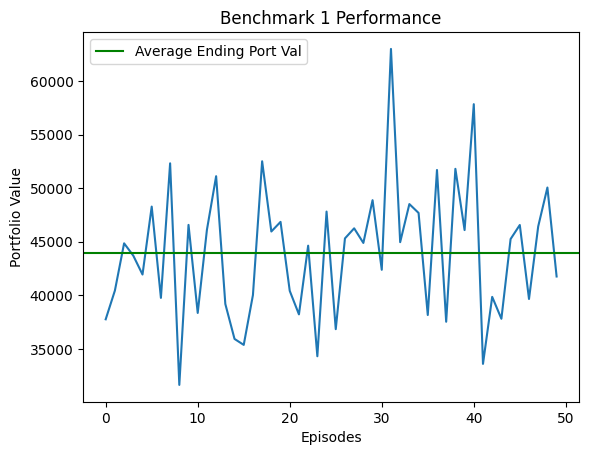

In [21]:
# Benchmark 1, Naive agent, random actions

# Initialize an array to store the ending portfolio values for each episode
end_port_val = np.array([])

# Run 50 episodes and obtain an average performance return
for i in range(50):
    agentRand = agent.DQNAgent(state_size, action_size, model)
    agentRand.epsilon = 1.0   # Random Actions, also as defaulted
    # Run a simulation in the testing environment
    port_val, actions = play_one_episode(agentRand, testenv, scaler, is_train=0)
    end_port_val = np.append(end_port_val, port_val[-1])

print(f'Benchmark 1 port ending val mean: {end_port_val.mean():.2f}, risk of the last episode: {np.std(np.array(port_val)):.2f}')

import matplotlib.pyplot as plt
plt.plot(end_port_val)
plt.axhline(y=end_port_val.mean(), color='g', linestyle='-', label='Average Ending Port Val')
plt.legend()
plt.xlabel('Episodes')
plt.ylabel('Portfolio Value')
plt.title('Benchmark 1 Performance')

In [22]:
# Benchmark 2, Traditional Allocation

def simu_result(data, allocation, initial_cash):
    """
    Simulate the portfolio value over time given an initial allocation and cash.

    Parameters:
    - data: A dataset used in the MarketEnv
    - allocation: A 1D numpy array representing the allocation to each trading asset.
    - initial_cash: The initial amount of cash available for investment.

    Returns:
    - A 1D numpy array representing the portfolio value over time.
    """

    n = len(allocation) - 1                   # Number of assets (excluding cash)
    init_allocation = allocation * initial_cash # Dollar allocation to each asset
    price = data[:, :n]                       # Given the dataset from the MarketEnv, extract the price data
    cash_rets = np.ones((price.shape[0], 1))  # Assume zero return for the cash position
    prices = np.concatenate((price, cash_rets), axis=1)     # Concatenate the price and cash data
    rets = prices / prices[0, :]              # Calculate the returns relative to the initial price
    pos = rets * init_allocation              # Dollar holdings at the end of each trading day

    return np.sum(pos, axis=1)                # Returns the sum of individual positions as the portfolio value

In [23]:
agentTrad = np.array([0.6, 0.4, 0, 0, 0])   # Traditional allocation, 60% in stocks, 40% in bonds
port_vals = simu_result(test_data, agentTrad, 50000.0)  # Simulate the portfolio value over the testing period
print(f'Benchmark 2 port ending val: {port_vals[-1]:.2f}, risk: {np.std(port_vals):.2f}')

Benchmark 2 port ending val: 51812.77, risk: 4423.91


In [24]:
# Trained Agent
agent2 = agent.DQNAgent(state_size, action_size, model)
agent2.epsilon = 0.0  # No randomness, actions purely chosen from the model output
agent2.load(f'agent1_{timestamp}.ckpt')  # Load the trained model, Agent 1

port_val2, actions2 = play_one_episode(agent2, testenv, scaler, is_train=0)

print(f'Trained Agent ending port val: {port_val2[-1]:.2f}, risk: {np.std(np.array(port_val2)):.2f}')

Trained Agent ending port val: 53736.19, risk: 2811.90


Plot the portfolio value change over the testing period

Text(0.5, 1.0, 'Comparison of Portfolio Values')

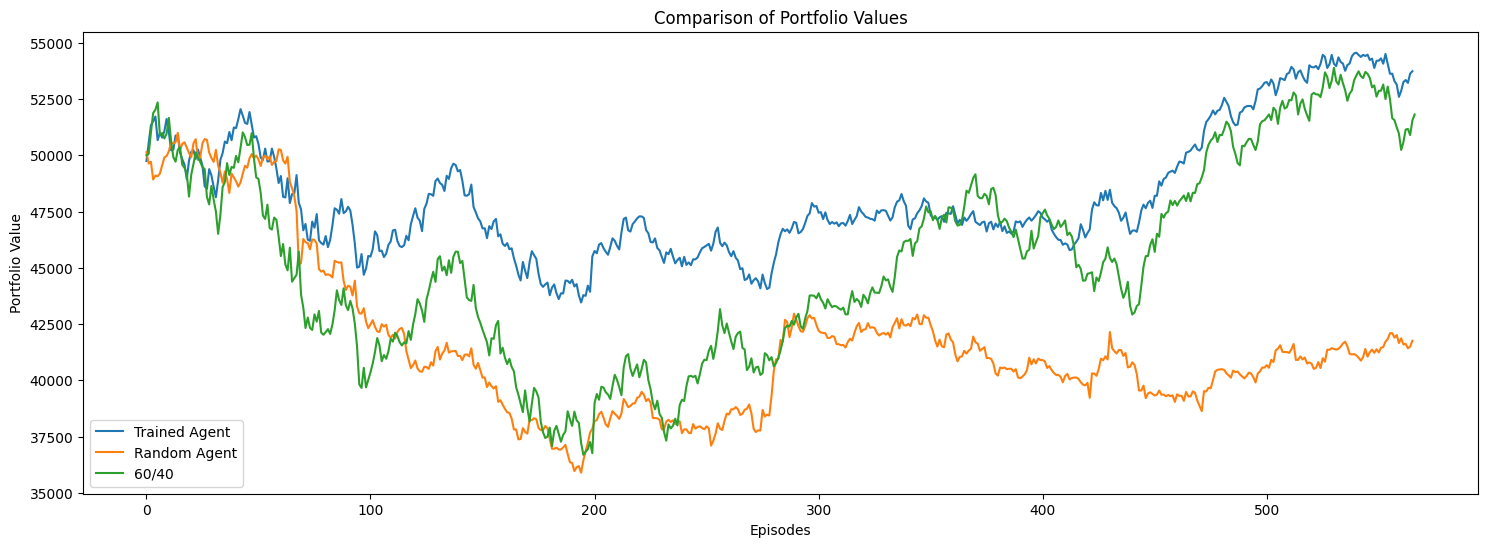

In [25]:
plt.figure(figsize=(18, 6))
plt.plot(port_val2, label='Trained Agent')
plt.plot(port_val, label='Random Agent')
plt.plot(port_vals, label='60/40')
plt.legend()
plt.xlabel('Episodes')
plt.ylabel('Portfolio Value')
plt.title('Comparison of Portfolio Values')

Testing results:

*   Benchmark 1 port ending val mean: 43941.08, risk of the last episode: 3484.51
*   Benchmark 2 port ending val: 51812.77, risk: 4423.91
*   Trained Agent ending port val: 53736.19, risk: 2811.90

The trained agent outperforms both benchmarks in terms of absolute dollar return and demonstrates significantly lower risk compared to the traditional 60/40 allocation.

# Analysis

We now examine the behavior of the trained agent to identify trends that could provide valuable insights for individual investors in their trading decisions.


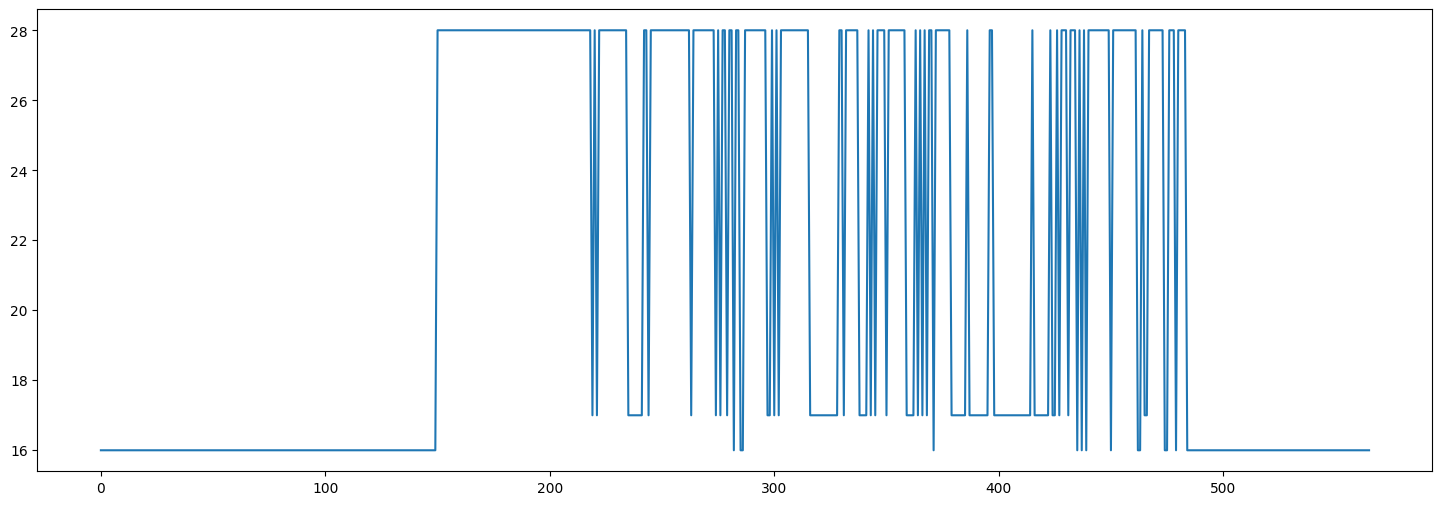

In [39]:
plt.figure(figsize=(18, 6))
plt.plot(actions2)

In [27]:
from collections import Counter

counter = Counter(actions2)
print(counter)

Counter({16: 245, 28: 229, 17: 92})


In [28]:
# ['QQQ', 'TLT', 'GLD', 'VIXM', Cash]
print('16: ', testenv.action_to_str(16))
print('28: ', testenv.action_to_str(28))
print('17: ', testenv.action_to_str(17))

16:  [0.5 0.  0.  0.  0.5]
28:  [0.25 0.25 0.25 0.   0.25]
17:  [0.5 0.  0.  0.5 0. ]


During the testing phase, despite having option to 31 possible actions, our agent consistently favored only 3 specific actions. These actions primarily involved investing in stocks, occasionally diversifying into cash or other ETFs. Remarkably, across multiple traing and testing trials, the agent consistently converged to a strategy allocating 50% of the investment to stocks and the rest to bonds/cash. This pattern mirrors the traditional 60/40 investment strategy commonly practiced in finance. This strategic convergence suggests a robust preference for a balanced portfolio approach.

# Conclusion

In this project, we explore the application of Deep Q-learning in portfolio management to dynamically rebalance an existing portfolio based on current market conditions. Our findings demonstrate that the trained agent is capable of achieving moderate outperformance compared to the benchmark. It is important to note that our project's framework is tailored towards guiding individual investors and may have limited applicability to institutional investors due to higher transaction costs and potential market impact associated with larger trades.

We acknowledge the inherent complexity and dynamism of financial markets, which present challenges in training agents under conditions that differ from those encountered during testing phases. Further extention to the project could incorporate a risk measure to calculate rewards, thereby optimizing for risk-adjusted returns. Other extensions include incorporating additional economic indicators, evaluating idiosyncratic factors impacting individual ETF performance, and analyzing price differences between ETFs and their underlying assets to enrich our dataset context. Furthermore, studying how the agent behaves with different ETFs will provide insights into its consistent or varying investment strategies.


# Reference


The foundation of the Deep Q-Learning set up is adopted from [this Github link](https://github.com/lazyprogrammer/machine_learning_examples/tree/master/pytorch)



# Appendix

## Data load

In [ ]:
def prep_data(start_date, end_date, tickers, exportfile):
  """
    Fetches stock data from Yahoo Finance for the specified tickers,
    merges it with economic indicator data, and saves the combined
    dataset to a CSV file.

    Parameters:
    - start_date (str): Start date for fetching stock data (YYYY-MM-DD).
    - end_date (str): End date for fetching stock data (YYYY-MM-DD).
    - tickers (list): List of stock tickers to fetch data for.

    Returns:
    - DataFrame: Merged DataFrame containing stock data and economic indicators.
    """
    # Initialize an empty DataFrame
  df = pd.DataFrame()
  close_idx = 0
  ret_idx = 1
  vol_idx = 2
  sma1_idx = 3
  sma2_idx = 4

  # Download stock data for each ticker
  for ticker in tickers:
      data = yf.download(ticker, start=start_date, end=end_date)
      df.insert(close_idx, ticker + ' Close', data['Adj Close'])
      df.insert(ret_idx, ticker + ' daily_ret', data['Adj Close'].pct_change())
      df.insert(vol_idx, ticker + ' Vol', data['Volume'])
      df.insert(sma1_idx, ticker + ' SMA1', data['Adj Close'].rolling(window=14).mean())
      df.insert(sma2_idx, ticker + ' SMA2', data['Adj Close'].rolling(window=60).mean())

      close_idx += 1
      ret_idx += 2
      vol_idx += 3
      sma1_idx += 4
      sma2_idx += 5

  # Add day of the month as a feature
  df['Day_in_month'] = df.index.day

  # Read the CSV file and convert 'Date' column to datetime
  econ = pd.read_csv('econindv2.csv')
  econ['Date'] = pd.to_datetime(econ['Date'])
  econ.set_index('Date', inplace=True)
  econ.loc[pd.to_datetime('2024-04-29')] = econ.loc[pd.to_datetime('2024-03-31')]
  df1 = econ.resample('1D').ffill()

  # Merge stock data and economic data on date index
  df2 = pd.merge(df, df1, left_index=True, right_index=True)
  df2.dropna(inplace=True)

  # Save the combined dataset to a CSV file
  df2.to_csv(exportfile, index=False)
  print(df2.shape)

  return df2

In [ ]:
output = '/content/drive/MyDrive/DQN/datav2.csv'
tickers = ['QQQ', 'TLT', 'GLD', 'VIXM']
df = prep_data(start_date='2015-01-30', end_date='2024-05-02', tickers=tickers, exportfile=output)

## Data analysis

We also plot the correlation matrix of closing price and daily returns to investigate the relationships between ETFs. The selection of ETFs are intentionally focused on those with lower correlations to enhance portfolio diversification and mitigate risk.

In [ ]:
# Correlation matrices
corr_matrix_close = close.corr()
corr_matrix_rets = dai_ret.corr()

# Plot heatmaps side by side using seaborn
plt.figure(figsize=(12, 6))

# Plot heatmap 1
plt.subplot(1, 2, 1)
sns.heatmap(corr_matrix_close, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Close prices')

# Plot heatmap 2
plt.subplot(1, 2, 2)
sns.heatmap(corr_matrix_rets, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Daily returns')

plt.tight_layout()  # Adjust spacing between plots

Finally, we create histograms and box plots for the daily returns. It is noticeable that the actual daily returns are more concentrated around the mean compared to a normal distribution. The box plots also indicate that the returns exhibit a significant central tendency, although a notable number of outliers are observed.

In [ ]:
from scipy.stats import norm
import matplotlib.pyplot as plt

fig, axes = plt.subplots(nrows=1, ncols=len(dai_ret.columns), figsize=(15, 5))

for i, col in enumerate(dai_ret.columns):
    ax = axes[i]
    dai_ret[col].hist(ax=ax, bins=50, density=True)

    # Fit a normal distribution to the data
    mu, std = norm.fit(dai_ret[col])
    xmin, xmax = ax.get_xlim()
    x = np.linspace(xmin, xmax, 100)
    p = norm.pdf(x, mu, std)

    # Plot the normal distribution curve
    ax.plot(x, p, 'k', linewidth=2)
    ax.set_title(col)

plt.tight_layout()

In [ ]:
plt.figure(figsize=(18, 6))

dai_ret.boxplot()
plt.title('Box Plot of Daily Returns')
plt.ylabel('Daily Returns')